In [1]:
import pandas as pd
from datetime import datetime

In [2]:
df = pd.read_csv('Data/raw_data/Transaction.csv')
df.head(10)

,Transaction ID,Customer ID,Product ID,Product Category,Purchase Amount,Purchase Date
0,1,238,45,Sensitive Skin Treatment,25,2024-03-24
1,1,238,35,Lip Care,15,2024-03-24
2,1,238,34,Lip Care,5,2024-03-24
3,1,238,4,Cleansers,20,2024-03-24
4,1,238,50,Pore Care,20,2024-03-24
5,2,379,35,Lip Care,15,2024-04-10
6,2,379,22,Moisturizers,40,2024-04-10
7,2,379,36,Lip Care,20,2024-04-10
8,2,379,34,Lip Care,5,2024-04-10
9,2,379,19,Moisturizers,25,2024-04-10


In [3]:
# Convert columns
df['Purchase Amount'] = pd.to_numeric(df['Purchase Amount'], errors='coerce')
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])

# A. Segmentation based on Purchase Behavior

In [4]:
# ---------------------- 1. Total Spend Segmentation ----------------------
total_spend = df.groupby('Customer ID')['Purchase Amount'].sum().reset_index()
total_spend.columns = ['Customer ID', 'Total Spend']
total_spend_q = total_spend['Total Spend'].quantile([0.2, 0.8]).to_dict()

def spend_category(spend):
    if spend <= total_spend_q[0.2]:
        return 'Low Spender'
    elif spend <= total_spend_q[0.8]:
        return 'Medium Spender'
    else:
        return 'High Spender'

total_spend['Spend Category'] = total_spend['Total Spend'].apply(spend_category)

In [5]:
# ---------------------- 2. Average Order Value Segmentation ----------------------
customer_txn = df.groupby(['Customer ID', 'Transaction ID'])['Purchase Amount'].sum().reset_index()
avg_order = customer_txn.groupby('Customer ID')['Purchase Amount'].mean().reset_index()
avg_order.columns = ['Customer ID', 'Average Order Value']
avg_order['Average Order Value'] = avg_order['Average Order Value'].round(2)
avg_order_q = avg_order['Average Order Value'].quantile([0.2, 0.8]).to_dict()

def order_value_category(avg):
    if avg <= avg_order_q[0.2]:
        return 'Budget Buyer'
    elif avg <= avg_order_q[0.8]:
        return 'Value Shopper'
    else:
        return 'Big Buyer'

avg_order['Order Value Category'] = avg_order['Average Order Value'].apply(order_value_category)

In [6]:
# ---------------------- 3. Frequency of Purchases Segmentation ----------------------
purchase_frequency = df.groupby('Customer ID')['Transaction ID'].nunique().reset_index()
purchase_frequency.columns = ['Customer ID', 'Purchase Frequency']

def frequency_category(freq):
    if freq == 1:
        return 'One-time Buyer'
    elif freq <= 3:
        return 'Occasional Buyer'
    else:
        return 'Frequent Buyer'

purchase_frequency['Frequency Category'] = purchase_frequency['Purchase Frequency'].apply(frequency_category)

In [8]:
# ---------------------- 4. Recency Segmentation ----------------------
latest_date = df['Purchase Date'].max()
recency_df = df.groupby('Customer ID')['Purchase Date'].max().reset_index()
recency_df['Days Since Last Purchase'] = (latest_date - recency_df['Purchase Date']).dt.days

def recency_category(days):
    if days <= 30:
        return 'Active Buyer'
    elif days <= 90:
        return 'At-risk Buyer'
    else:
        return 'Lapsed Buyer'

recency_df['Recency Category'] = recency_df['Days Since Last Purchase'].apply(recency_category)

In [9]:
# ---------------------- Merge All Segmentations ----------------------
segmentation = total_spend.merge(avg_order, on='Customer ID')
segmentation = segmentation.merge(purchase_frequency, on='Customer ID')
segmentation = segmentation.merge(recency_df[['Customer ID', 'Recency Category']], on='Customer ID')

In [10]:
segmentation.head(10)

,Customer ID,Total Spend,Spend Category,Average Order Value,Order Value Category,Purchase Frequency,Frequency Category,Recency Category
0,1,1010,Medium Spender,84.17,Value Shopper,12,Frequent Buyer,At-risk Buyer
1,2,1370,High Spender,97.86,Value Shopper,14,Frequent Buyer,At-risk Buyer
2,3,815,Medium Spender,81.50,Value Shopper,10,Frequent Buyer,Active Buyer
3,4,465,Low Spender,77.50,Budget Buyer,6,Frequent Buyer,Lapsed Buyer
4,5,760,Medium Spender,84.44,Value Shopper,9,Frequent Buyer,Active Buyer
5,6,705,Medium Spender,64.09,Budget Buyer,11,Frequent Buyer,At-risk Buyer
6,7,670,Medium Spender,74.44,Budget Buyer,9,Frequent Buyer,At-risk Buyer
7,8,790,Medium Spender,87.78,Value Shopper,9,Frequent Buyer,Active Buyer
8,9,640,Low Spender,80.00,Budget Buyer,8,Frequent Buyer,Active Buyer
9,10,1190,High Spender,85.00,Value Shopper,14,Frequent Buyer,Active Buyer


In [11]:
segmentation.to_csv("Data/results/Segmentation_based_on_Purchase_Behavior.csv", index=False)

# B. Segmentation based on Purchase Patterns


In [13]:
# Group by Customer ID and count number of unique transactions
purchase_counts = df.groupby('Customer ID')['Transaction ID'].nunique().reset_index()
purchase_counts.columns = ['Customer ID', 'Purchase Count']

In [14]:
# Define purchase pattern category
def purchase_pattern_category(count):
    if count == 1:
        return 'New Customer'
    elif count >= 5:
        return 'Loyal Customer'
    else:
        return 'Returning Customer'

purchase_counts['Purchase Pattern'] = purchase_counts['Purchase Count'].apply(purchase_pattern_category)

In [15]:
# ------------------- Seasonal Buyers Segmentation -------------------
# Extract month from Purchase Date
df['Purchase Month'] = df['Purchase Date'].dt.month

# Count number of purchases in each month per customer
monthly_purchase = df.groupby(['Customer ID', 'Purchase Month']).size().unstack(fill_value=0)

In [16]:
# Define holiday month(s), here assumed December (12) for this dataset
holiday_months = [12]

In [18]:
# Determine buyer seasonality
def seasonality_category(row):
    total_purchases = row.sum()
    holiday_purchases = row[holiday_months].sum()
    if holiday_purchases / total_purchases >= 0.6:
        return 'Holiday Shopper'
    elif row[row > 0].count() >= 6:
        return 'Regular Season Buyer'
    else:
        return 'Off-season Shopper'

In [19]:
monthly_purchase['Seasonality Category'] = monthly_purchase.apply(seasonality_category, axis=1)

In [20]:
# ------------------- Merge both segmentations -------------------
pattern_segmentation = purchase_counts.merge(monthly_purchase[['Seasonality Category']], on='Customer ID')
pattern_segmentation.head(10)

,Customer ID,Purchase Count,Purchase Pattern,Seasonality Category
0,1,12,Loyal Customer,Regular Season Buyer
1,2,14,Loyal Customer,Regular Season Buyer
2,3,10,Loyal Customer,Off-season Shopper
3,4,6,Loyal Customer,Regular Season Buyer
4,5,9,Loyal Customer,Regular Season Buyer
5,6,11,Loyal Customer,Regular Season Buyer
6,7,9,Loyal Customer,Regular Season Buyer
7,8,9,Loyal Customer,Regular Season Buyer
8,9,8,Loyal Customer,Regular Season Buyer
9,10,14,Loyal Customer,Regular Season Buyer


In [38]:
pattern_segmentation.to_csv("Data/results/Segmentation_based_on_Purchase_Pattern.csv", index=False)

# C. Segmentation based on Basket Composition

In [22]:
# Calculate basket value: total amount per transaction
basket_value = df.groupby(['Customer ID', 'Transaction ID'])['Purchase Amount'].sum().reset_index()
basket_avg = basket_value.groupby('Customer ID')['Purchase Amount'].mean().reset_index()
basket_avg.columns = ['Customer ID', 'Average Basket Value']

In [23]:
# --------------------- Basket Value Segmentation ---------------------
# Quantiles for basket value segmentation
basket_quantiles = basket_avg['Average Basket Value'].quantile([0.2, 0.8]).to_dict()

# Categorize customers by basket value
def basket_value_category(value):
    if value <= basket_quantiles[0.2]:
        return 'Low Basket Buyer'
    elif value <= basket_quantiles[0.8]:
        return 'Moderate Basket Buyer'
    else:
        return 'High Basket Buyer'

basket_avg['Basket Value Category'] = basket_avg['Average Basket Value'].apply(basket_value_category)

In [24]:
# Count items per transaction per customer
items_per_txn = df.groupby(['Customer ID', 'Transaction ID']).size().reset_index(name='Item Count')
avg_items = items_per_txn.groupby('Customer ID')['Item Count'].mean().reset_index()
avg_items.columns = ['Customer ID', 'Average Items per Transaction']

In [33]:
avg_items.columns

Index(['Customer ID', 'Average Items per Transaction', 'Item Count Category'], dtype='object')

In [34]:
# --------------------- Items per Transaction Segmentation ---------------------
# Categorize customers by item count
def item_count_category(avg):
    if avg <= 2:
        return 'Selective Buyer'
    elif avg >= 5:
        return 'Bulk Buyer'
    else:
        return 'Mixed Buyer'

avg_items['Item Count Category'] = avg_items['Average Items per Transaction'].apply(item_count_category)

In [36]:
# --------------------- Merge Segmentations ---------------------
basket_segmentation = basket_avg.merge(avg_items, on='Customer ID')
basket_segmentation['Average Basket Value'] = basket_segmentation['Average Basket Value'].round(2)
basket_segmentation['Average Items per Transaction'] = basket_segmentation['Average Items per Transaction'].round(2)
basket_segmentation.head(10)

,Customer ID,Average Basket Value,Basket Value Category,Average Items per Transaction,Item Count Category
0,1,84.17,Moderate Basket Buyer,3.58,Mixed Buyer
1,2,97.86,Moderate Basket Buyer,3.64,Mixed Buyer
2,3,81.50,Moderate Basket Buyer,3.30,Mixed Buyer
3,4,77.50,Low Basket Buyer,3.00,Mixed Buyer
4,5,84.44,Moderate Basket Buyer,3.11,Mixed Buyer
5,6,64.09,Low Basket Buyer,2.91,Mixed Buyer
6,7,74.44,Low Basket Buyer,3.11,Mixed Buyer
7,8,87.78,Moderate Basket Buyer,3.33,Mixed Buyer
8,9,80.00,Low Basket Buyer,3.38,Mixed Buyer
9,10,85.00,Moderate Basket Buyer,3.57,Mixed Buyer


In [64]:
basket_segmentation.to_csv("Data/results/Segmentation_based_on_Basket_Composition.csv", index=False)

# Segmentation Strategies

|        **Strategy**        |                                                                 **Description**                                                                 |                                      **Benefit**                                      |
|:-------------------------:|:--------------------------------------------------------------------------------------------------------------------------------------------------:|:--------------------------------------------------------------------------------------:|
| Total Spending Segmentation            | Categorizes customers into Low, Medium, and High Spenders based on cumulative purchase value over time.                                                                      | Enables targeted promotions—budget offers for low spenders, upsells for mid-tier, and VIP perks for top spenders—driving engagement and maximizing revenue. |
| Average Spending Segmentation          | Segments customers into Budget Buyers, Value Shoppers, and Big Buyers based on their average spend per transaction.                                                          | Helps tailor product recommendations, pricing, and incentives that align with each group’s spending behavior, increasing order value and satisfaction.       |
| Purchase Frequency Segmentation        | Classifies customers as One-time Buyers, Occasional Buyers, or Frequent Buyers based on how often they make purchases.                                                       | Supports retention strategies, identifies loyal customers for rewards, and enables timely re-engagement of less frequent shoppers.                           |
| Recency Segmentation (RFM)             | Groups customers into Active, At-risk, and Lapsed Buyers based on how recently they made a purchase.                                                                         | Helps prioritize outreach, reduce churn, and reactivate dormant customers through personalized timing of campaigns.                                           |
| Purchase Pattern Segmentation          | Differentiates New Customers (1st purchase), Returning Customers (2–4 purchases), and Loyal Customers (5+ or consistent behavior).                                           | Allows businesses to tailor onboarding, recognition, and loyalty-building efforts to match the customer’s purchase journey.                                  |
| Seasonal Buying Behavior               | Categorizes customers into Holiday Shoppers, Regular Season Buyers, and Off-season Shoppers based on the timing of their purchases.                                          | Enables precise campaign scheduling, inventory planning, and seasonal promotion targeting to align with customer shopping behavior.                          |
| Basket Value Segmentation             | Segments customers based on the average value of their transaction into Low, Moderate, and High Basket Buyers.                                                                 | Helps identify high-spending customers for premium targeting and optimize promotions to encourage higher value purchases.      |
| Items per Transaction Segmentation    | Classifies customers by the average number of items purchased per transaction as Selective Buyers (1–2 items), Mixed Buyers, or Bulk Buyers (5+ items).                       | Enables tailored product bundling, simplifies inventory planning, and supports more relevant marketing messages.               |

# Visualizing Customer Segmentation

In [41]:
import matplotlib.pyplot as plt

In [42]:
# 1. Recency Segmentation
recency_counts = recency_df['Recency Category'].value_counts()

# 2. Purchase Pattern Segmentation: New, Returning, Loyal Customers
purchase_pattern_counts = purchase_counts['Purchase Pattern'].value_counts()

# 3. Seasonal Buying Behavior
seasonality_counts = monthly_purchase['Seasonality Category'].value_counts()

# 4. Basket Value Segmentation
basket_value_counts = basket_segmentation['Basket Value Category'].value_counts()

# 5. Items per Transaction Segmentation
item_count_counts = basket_segmentation['Item Count Category'].value_counts()

In [50]:
# Create pie chart function
def plot_pie_chart(data, title):
    plt.figure(figsize=(5,5))
    plt.pie(data.values, labels=data.index, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'white'})
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

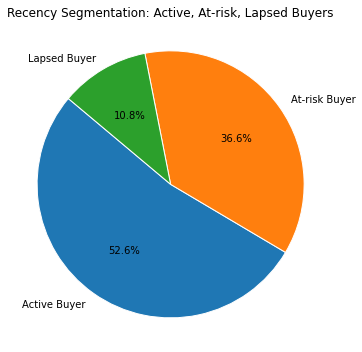

In [51]:
plot_pie_chart(recency_counts, 'Recency Segmentation: Active, At-risk, Lapsed Buyers')

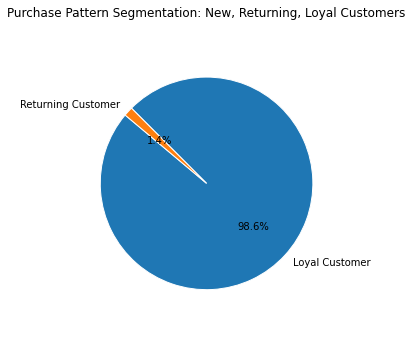

In [52]:
plot_pie_chart(purchase_pattern_counts, 'Purchase Pattern Segmentation: New, Returning, Loyal Customers')

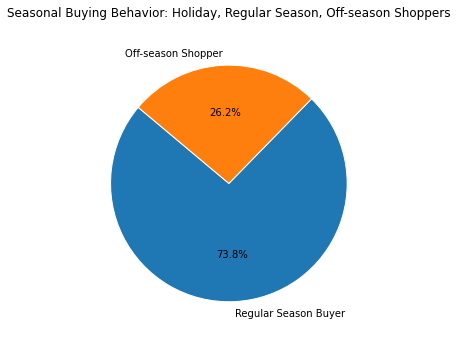

In [63]:
plot_pie_chart(seasonality_counts, 'Seasonal Buying Behavior: Holiday, Regular Season, Off-season Shoppers')

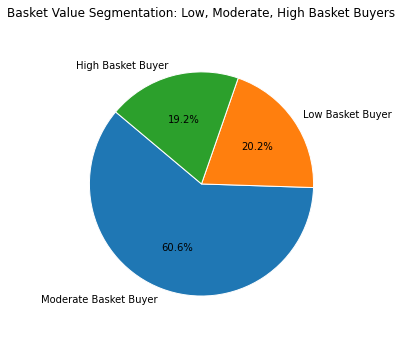

In [54]:
plot_pie_chart(basket_value_counts, 'Basket Value Segmentation: Low, Moderate, High Basket Buyers')

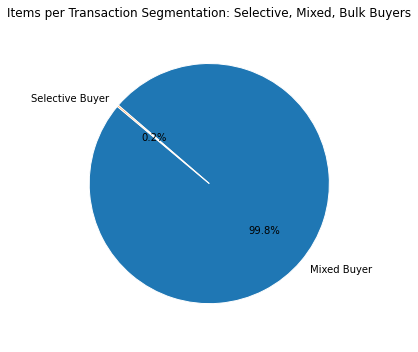

In [55]:
plot_pie_chart(item_count_counts, 'Items per Transaction Segmentation: Selective, Mixed, Bulk Buyers')